# Model Dependence on Class Imbalance
In this section we study the susceptibility of usual binary classifications algorithms when
dealing with imbalanced datasets (cf. definition of imabalanced dataset somewhere).
The exploration of the model/imbalance rate interaction is carried out, in principle, via the impact of imbalance on classification metrics of the typical classification models used in the literature and the industry.

# Imports

In [76]:
# basics
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Any, List, Dict
from matplotlib import pyplot as plt


# sklearn
from sklearn.datasets import make_classification


# Data
Synthetic data is generated using sciki-learn functionalities.

In [2]:
def create_imbalanced_binary_classification(n_samples: int = 1000, 
                                            n_features: int = 4,
                                            n_informative: int = None, 
                                            imbalance: float = 0.1,
                                            random_state: int = 42) -> pd.DataFrame:
    """Creates an imbalanced dataset for binary classification
    Parameters
    ----------
    n_samples: int, default = 1000,
            number of samples to generate
    n_features: int default = 4,
            number of features (not all are informative)
    n_informative: int default = None,
            number of informative features
            if none is specified floor(n_features/2) 
            will be taken
    imbalance: float, default = 0.1
            proportion of the minority class
    random_state: int, default = 42
    Returns
    -------
    data: pd.DataFrame,
        dataframe with n_features + 1 columns
    """
    if n_informative == None:
        n_informative = int(n_features/2)
    weights = [1 - imbalance, imbalance]
    X, y = make_classification(n_samples = n_samples,
                                n_features = n_features,
                                n_classes=2,
                                n_informative = n_informative,
                                weights = weights,                
                                random_state = random_state)
    column_names = [ f'feature_{i}' for i in np.arange(n_features)]      
    data = pd.concat([pd.DataFrame(X, columns = column_names), pd.DataFrame(y, columns = ['target'])], axis = 1)
    return data, column_names

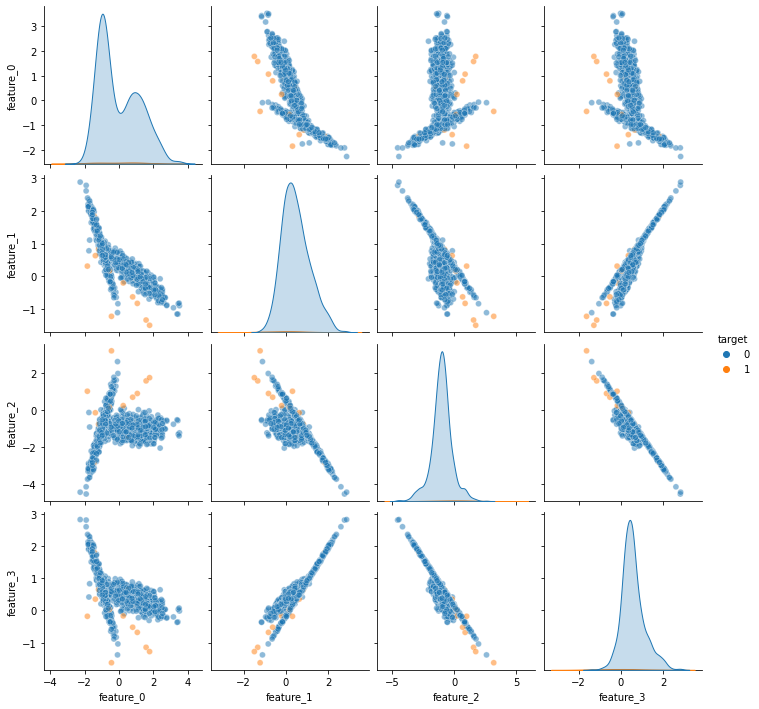

In [52]:
n_samples = 10**3
n_features = 4
imbalance = 0.01
n_informative = 2
data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance)
sns.pairplot(data, hue = 'target', plot_kws = {'alpha' : 0.5})


# Decision Tree Classifier


In [53]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [108]:
random_state = 42
X, y = data[column_names], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y)
clf = DecisionTreeClassifier(max_leaf_nodes = 3, random_state = random_state)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)

Let us have a look at the details of the tree 

In [109]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

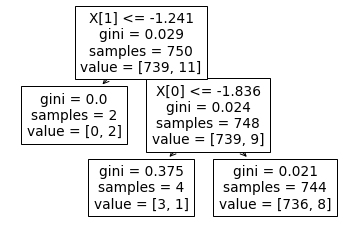

In [110]:
tree.plot_tree(clf)
plt.show()

# Experiment 1: Impact on Performance
We will compare the imbalance impact on the classifier performance. Our benchmark model will be a logistic regression.

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, matthews_corrcoef,  precision_recall_curve

In [133]:
def compute_metrics(y_true: List, y_proba: List) -> pd.DataFrame:
    """Computes several classification metrics at once
    Parameters
    ----------
    y_true: list
        list with ground truth events
    y_proba: list
        array of predicted probabilities
    Returns
    -------
    metrics: pd.DataFrame
    """
    metrics = {}
    # ROC AUC
    metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    # ROC Curve
    fpr, tpr, thresholds_roc = roc_curve(y_true = y_true, y_score = y_proba)
    metrics['roc_curve'] = {}
    metrics['roc_curve']['fpr'] = fpr
    metrics['roc_curve']['tpr'] = tpr
    metrics['roc_curve']['thresholds'] = thresholds_roc
    # Precision-Recall curve
    
    metrics['pr_curve'] = {}
    precision, recall, thresholds_pr = precision_recall_curve(y_true = y_true, probas_pred = y_proba)
    metrics['pr_curve']['precision'] = precision
    metrics['pr_curve']['recall'] = recall
    metrics['pr_curve']['thresholds'] = thresholds_pr

    return pd.DataFrame([metrics])


Let us see how the performance changes for different imbalance ratios:

In [191]:
n_samples = 10**4
n_features = 4
n_informative = 2
metrics = {}
imbalances = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005]
random_state = 42
for imbalance in imbalances:
    print(f'Minority class proportion: {imbalance}')
    metrics[imbalance] = {}
    # Create dataset
    data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance)
    # Train test split
    X, y = data[column_names], data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y)
    
    # Logistic Regression
    print('\tLog Regression ...')
    lr_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression())])
    lr_pipeline.fit(X_train, y_train)
    y_proba = lr_pipeline.predict_proba(X_test)
    metrics[imbalance]['logreg'] = compute_metrics(y_true = y_test, y_proba = y_proba[:,1])
    del y_proba
    
    # Decision Tree
    print('\tDecision Tree ...')
    dt_clf = DecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    y_proba = dt_clf.predict_proba(X_test)
    metrics[imbalance]['dt'] = compute_metrics(y_true = y_test, y_proba= y_proba[:,1])


Minority class proportion: 0.5
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.3
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.2
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.1
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.05
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.01
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.005
	Log Regression ...
	Decision Tree ...


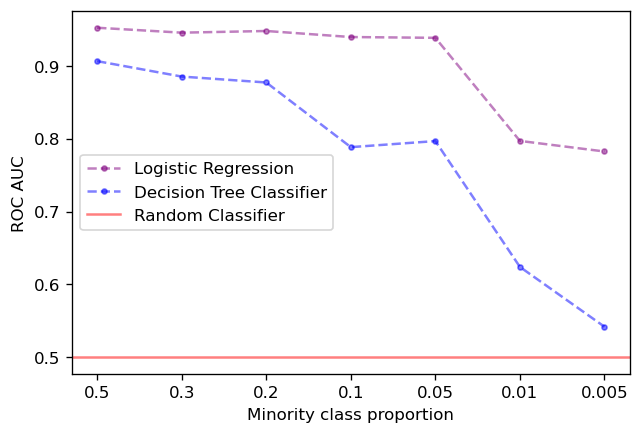

In [196]:
logreg_rocaucs = [metrics[x]['logreg']['roc_auc'].values for x in metrics.keys()]
dt_rocaucs = [metrics[x]['dt']['roc_auc'].values for x in metrics.keys()]
f, ax = plt.subplots(dpi = 120)
# Logistic Regression
ax.plot(logreg_rocaucs, marker = '.', linestyle = '--',
            color = 'purple', label = 'Logistic Regression',
            alpha = 0.5)
ax.set_xticks(range(len(imbalances)))
ax.set_xticklabels(imbalances)
ax.set_xlabel('Minority class proportion')
# Decision Tree Classifier
ax.plot(dt_rocaucs, marker = '.', linestyle = '--',
            color = 'blue', label = 'Decision Tree Classifier',
            alpha = 0.5)
ax.set_ylabel('ROC AUC')
ax.axhline(y = 0.5, color = 'r', alpha = 0.5, label = 'Random Classifier')
ax.legend()



# Experiment 2: Changing split function (Hellinger Distance)